# Deep kernel learning for data reconstruction and automated experiment

*Prepared by Maxim Ziatdinov (January 2022)*

This notebook demonstrates how to use deep kernel learning (DKL) for data reconstruction and automated experiments. We will be using a pre-acquired STEM-EELS experimental dataset on plasmonic nanoparticles from Kevin Roccapriore.

The DKL can be viewed as an extension of Gaussian process (GP) for high-dimensional data. Hence, we first briefly overview the standard GP. GP is a powerful tool for reconstructing with quantified uncertainty an unknown  (“black-box”) function  over a low-dimensional parameter space. Formally, given a set of observed data points $(x_i, y_i)_{i=1, ..., N}$ and assuming normally distributed observation noise $𝜀$, the GP can be defined as

$$y_i= f(x_i) + 𝜀_i$$
$$f ∼ MVN(0; K(x_i, x_j))$$

where $MVN$ stands for Multivariate Normal Distribution, $K$ is a kernel function,  and $f(x)$ is a "black-box" function we try to reconstruct. The functional form of the kernel $K$ is chosen prior to the experiment, and its hyperparameters are inferred from the observations using either Markov chain Monte Carlo methods or stochastic variational inference. 

Once the GP model is trained, we can use it to make a probabilistic prediction on new inputs. Specifically, the predictive mean and covariance on the new data $X_*$ are given by

$$𝜇_*=K(X_*,X|𝜃)K(X,X|𝜃)^{-1}y$$
$$𝛴_*=K(X_*,X_*|𝜃)-K(X_*,X|𝜃)K(X,X|𝜃)^{-1}K(X,X_*|𝜃)$$

where 𝜃 are learned GP kernel parameters. Note that we absorbed model noise into the computation of kernel function. The predictive uncertainty is given by the square root of the diagonal elements of the covariance matrix $U_*=\sqrt{\text{diag}(𝛴_*)}$.

The GP predictive mean and uncertainty can then be used to derive an acquisition function for selecting the next point to measure. Depending on the form of acqusition function, this can be referred to as active learning (discovering the overall data distribution) or Bayesian optimization (identifying global maximum or minimum). Here, we will refer to both of them as "active learning."

A significant limitation of the standard GP (and GP-based active learning) is that it does not scale well with the dimensionality of the parameter space. Another limitation is that the standard GP
does not, strictly speaking, learn representations of data which precludes us from using information from different experimental modalities to assist in selecting the next measurement point.

To address these issues, we have adapted a [deep kernel learning](https://arxiv.org/abs/1511.02222) (DKL) approach. DKL can be understood as a hybrid of deep neural network (DNN) and GP. The DNN serves as a feature extractor that allows reducing the complex high-dimensional features to low-dimensional descriptors on which a standard GP kernel operates. The parameters of DNN and GP kernel are inferred jointly in an end-to-end fashion. Practically, the DKL training inputs are usually patches from an (easy-to-acquire) structural image over a large field of view, and training targets represent a physical property of interest derived from the (hard-to-acquire) spectra measured in those patches. The DKL output on the new inputs (image patches for which there are no measured spectra) is the expected property value and associated uncertainty, which can be used to derive the next measurement point in the automated experiments. 

Formally, we define a deep kernel as

$$k_{DKL}(x_i,x_j|w,𝜃)=k_{base}(g(x_i|w),g(x_j|w)|𝜃)$$

where $g$ is a neural network with weights $w$ and $k_{base}$ is a standard GP kernel. The parameters of neural network and GP base
kernel are learned simultaneously via Markov chain Monte Carlo sampling techniques or a stochastic variational inference. The trained DKL model is then used for obtaining predictive mean and uncertainty and deriving the acquisition function the same way as for the standard GP.

GPax package has the fully Bayesian DKL (weights of neural network and GP hyperparameters are inferred using Hamiltonian Monte Carlo) and the Variational Inference approximation of DKL, viDKL. The fully Bayesian DKL can provide an asymptotically exact solution but is too slow for most automated experiments. Hence, for the latter, we use the viDKL.

## Installation

In [ ]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 KB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 54.1 MB/s eta 0:00:00


## Imports

In [ ]:
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

filterwarnings("ignore", module="haiku._src.data_structures")

## Prepared data

Download training data:

In [ ]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [ ]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [ ]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra)



In [ ]:
window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

/usr/local/lib/python3.8/dist-packages/atomai/utils/img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2820, 16, 16), (2820, 93))

Normalize data:

In [ ]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

### Scalarizer
Next, we select a scalarizer function that will convert a measured spectrum into a scalar physical descriptor. The scalarizer defines the measure of physical interest to the response and acts as a reward towards the specific behavior in the experiment. The scalarizer can be created in almost unlimited number of ways. For example, it can be based
on the gross characteristic of the spectrum, such as area under curve, integrated intensity within certain energy range, area or width of hysteresis loop, etc. It can incorporate the physical model and physics-based analysis, for example converting predicted spectrum to specific materials parameters. It can be based on hybrid criteria defined via combinations of functional fits, decision trees, etc. Finally, it can be crowd sourced – if the neural network has been trained by human labelled data, or other form of expert system can be used. Ultimately however, the scalarizer should define the measure of physical interest much like the human operator would do.

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of the most prominent plasmonic peak, but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First, let's do it for a single spectrum:

25 0.2826059331244979


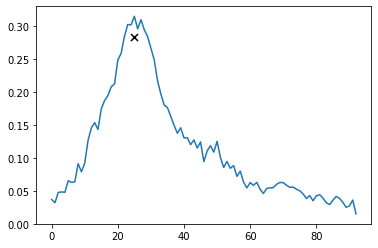

In [ ]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Now for all the data:

In [ ]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

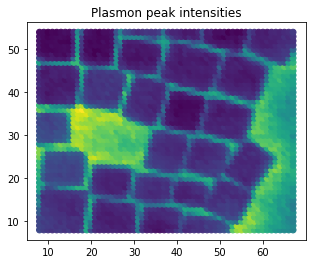

In [ ]:
_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)
ax.set_title('Plasmon peak intensities')
ax.set_aspect('equal')

## Reconstruction from partial data
Here we demonstrate how to use DKL to learn a correlative structure-property relationship from a relatively small number of image-(scalarized)spectrum pairs and then use the trained model to predict a targeted physical property for the entire image space.

Prepare data:

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Split the data in such a way that we use only a relatively small part of data (to the left of the vertical dashed line in the figure below) to train a DKL model and then use the trained model to make a prediction of the "unmeasured" plasmon peak values (the part to the right of the vertical dashed line):

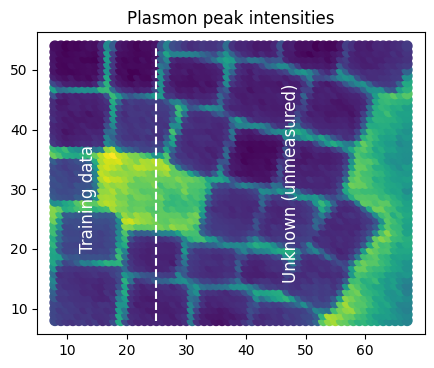

In [ ]:
split_ = 25
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

_, ax = plt.subplots(dpi=100)
ax.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax.text(split_ // 2, 20, 'Training data', c='w', size=12, rotation=90)
ax.text((split_ + indices[:, 1].max()) // 2, 15, 'Unknown (unmeasured)', c='w', size=12, rotation=90)
ax.set_title('Plasmon peak intensities');
ax.set_aspect('equal')

Initialize and train a DKL model:

In [ ]:
data_dim = X_train.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:19<00:00,  5.09it/s, init loss: 21019.9002, avg. loss [96-100]: 18368.3134]


Inferred GP kernel parameters
k_length         [13.3505 23.2036]
k_scale          0.1452
noise            0.0115


Use the trained model to make a probabilsitic prediction for all the image patches:

In [ ]:
mean, var = dkl.predict(key2, X)

Visualize predictive mean and uncertainty:

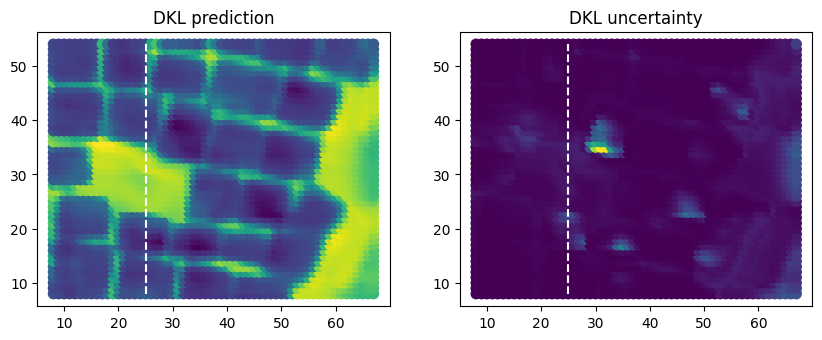

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), dpi=100)
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax1.set_title("DKL prediction")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax2.set_title("DKL uncertainty")
ax1.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
for _ax in fig.axes:
    _ax.set_aspect('equal')

We can also visualize the latent/embedding space:

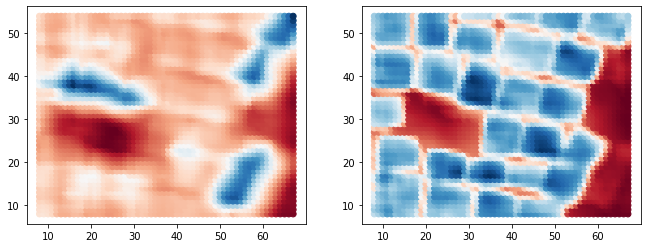

In [ ]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## Active learning
Now we are going to use DKL to actively learn (local) structures where a particular physical behavior or property (here, plasmon resonance peak) is maximized. Starting with just a few "measured" point, we use DKL to obtain predictive mean and variance for our property of interest over the entire parameter space, and then use them to compute the upper confedence bound (UCB) acquisition function for sampling the next measurement point.

Prepare the data

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Get the initial measurements aka training points. Here ```X_measured``` are the already measured points, that is, the image patches for which there are measured spectra, whose scalarized values are stored in ```y_measured```. The ```X_unmeasured``` are unmeasured points, that is, image patches for which there are yet no measured spectra. 

In [ ]:
# use only 0.02% of grid data points as initial training points
(X_measured, X_unmeasured, y_measured, y_unmeasured,
  indices_measured, indices_unmeasured) = train_test_split(
      X, y, indices_all, test_size=0.998, shuffle=True, random_state=1)
  
seed_points = len(X_measured)

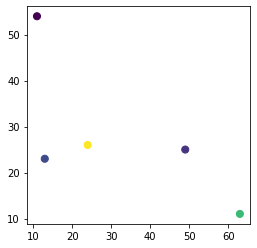

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_measured[:, 1], indices_measured[:, 0], s=50, c=y_measured)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/80


100%|██████████| 100/100 [00:01<00:00, 59.81it/s, init loss: 20124.5998, avg. loss [96-100]: 19061.5936]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2994
noise            0.1452


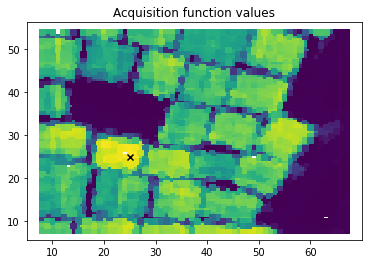

2/80


100%|██████████| 100/100 [00:01<00:00, 69.93it/s, init loss: 20126.0083, avg. loss [96-100]: 19062.0954]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3185
noise            0.1395


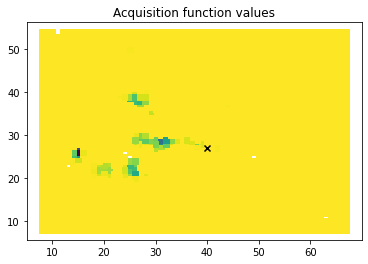

3/80


100%|██████████| 100/100 [00:01<00:00, 69.75it/s, init loss: 20127.2665, avg. loss [96-100]: 19062.2108]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3075
noise            0.1257


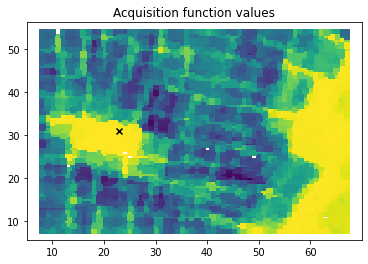

4/80


100%|██████████| 100/100 [00:01<00:00, 58.62it/s, init loss: 20128.6552, avg. loss [96-100]: 19062.5365]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3206
noise            0.1202


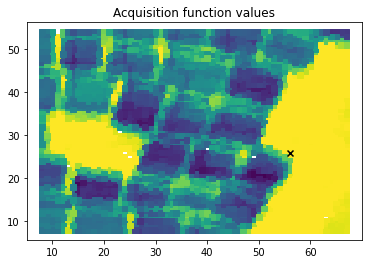

5/80


100%|██████████| 100/100 [00:01<00:00, 66.93it/s, init loss: 20129.8634, avg. loss [96-100]: 19062.6827]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.311
noise            0.11320000000000001


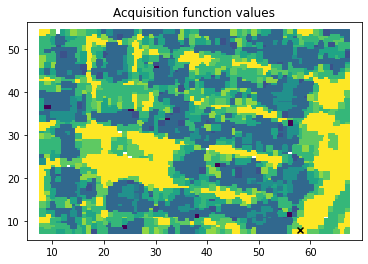

6/80


100%|██████████| 100/100 [00:01<00:00, 67.43it/s, init loss: 20131.2385, avg. loss [96-100]: 19062.8224]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3195
noise            0.1066


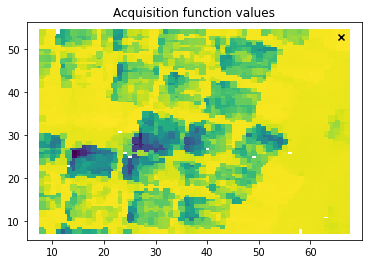

7/80


100%|██████████| 100/100 [00:02<00:00, 48.88it/s, init loss: 20132.4961, avg. loss [96-100]: 19062.9067]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3118
noise            0.1018


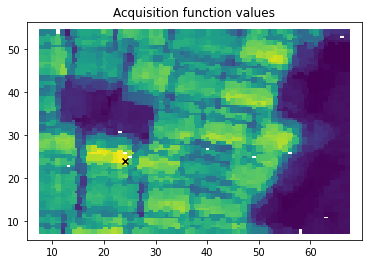

8/80


100%|██████████| 100/100 [00:01<00:00, 66.74it/s, init loss: 20133.8647, avg. loss [96-100]: 19063.1443]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3204
noise            0.10010000000000001


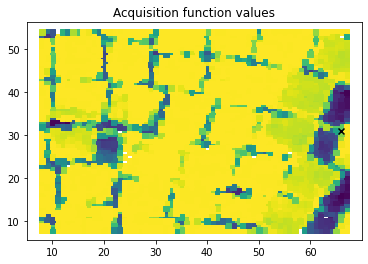

9/80


100%|██████████| 100/100 [00:01<00:00, 68.17it/s, init loss: 20135.1571, avg. loss [96-100]: 19075.5292]



Inferred GP kernel parameters
k_length         [0.611  0.8434]
k_scale          0.254
noise            0.0632


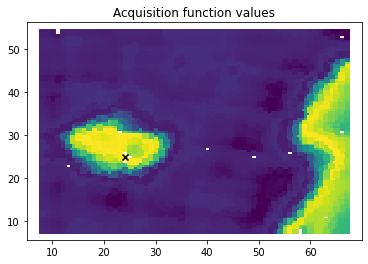

10/80


100%|██████████| 100/100 [00:01<00:00, 66.58it/s, init loss: 20136.5335, avg. loss [96-100]: 19063.3180]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.332
noise            0.09290000000000001


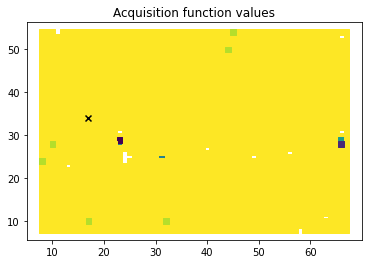

11/80


100%|██████████| 100/100 [00:01<00:00, 68.14it/s, init loss: 20137.9915, avg. loss [96-100]: 19063.8745]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3415
noise            0.09630000000000001


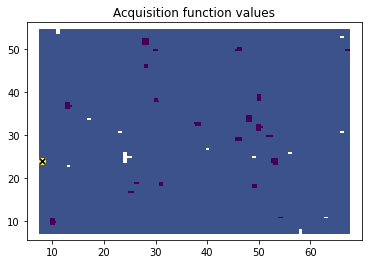

12/80


100%|██████████| 100/100 [00:01<00:00, 67.42it/s, init loss: 20139.2947, avg. loss [96-100]: 19063.7589]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3453
noise            0.0912


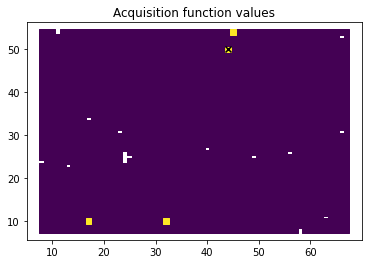

13/80


100%|██████████| 100/100 [00:01<00:00, 65.49it/s, init loss: 20140.5368, avg. loss [96-100]: 19064.0041]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33840000000000003
noise            0.0916


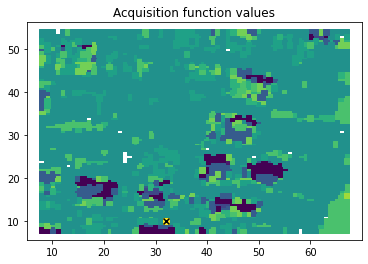

14/80


100%|██████████| 100/100 [00:01<00:00, 58.78it/s, init loss: 20141.6923, avg. loss [96-100]: 19064.0275]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3337
noise            0.0892


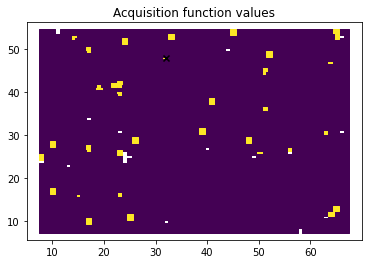

15/80


100%|██████████| 100/100 [00:01<00:00, 56.61it/s, init loss: 20142.9436, avg. loss [96-100]: 19064.3707]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3272
noise            0.0907


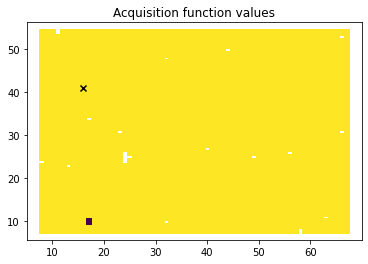

16/80


100%|██████████| 100/100 [00:01<00:00, 55.70it/s, init loss: 20144.1937, avg. loss [96-100]: 19064.5616]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.322
noise            0.09050000000000001


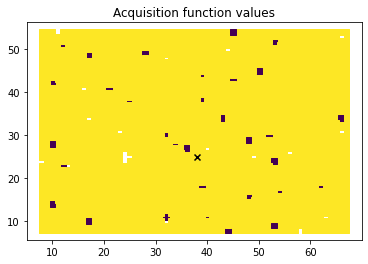

17/80


100%|██████████| 100/100 [00:01<00:00, 64.87it/s, init loss: 20145.4068, avg. loss [96-100]: 19064.5981]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31820000000000004
noise            0.0886


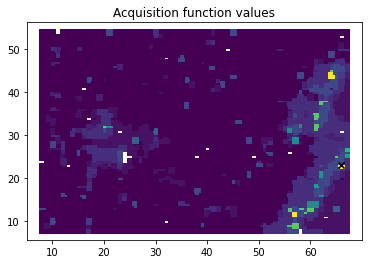

18/80


100%|██████████| 100/100 [00:01<00:00, 56.49it/s, init loss: 20146.7408, avg. loss [96-100]: 19064.5745]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3216
noise            0.0864


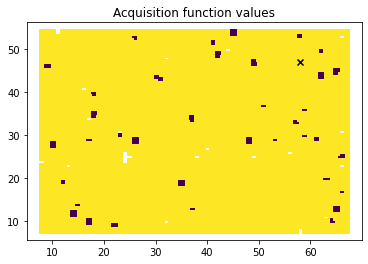

19/80


100%|██████████| 100/100 [00:01<00:00, 65.94it/s, init loss: 20147.9676, avg. loss [96-100]: 19092.5361]



Inferred GP kernel parameters
k_length         [1.5667 1.743 ]
k_scale          0.2469
noise            0.0396


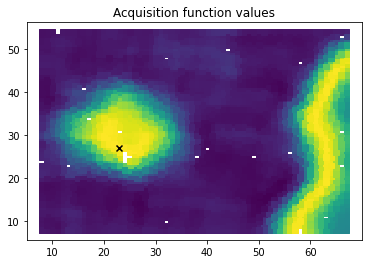

20/80


100%|██████████| 100/100 [00:01<00:00, 67.39it/s, init loss: 20149.3468, avg. loss [96-100]: 19094.3749]



Inferred GP kernel parameters
k_length         [2.0131 1.9921]
k_scale          0.2258
noise            0.040600000000000004


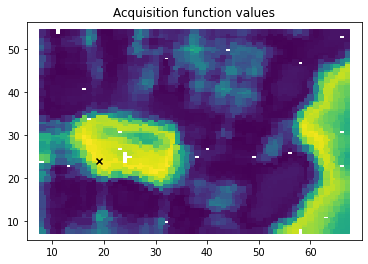

21/80


100%|██████████| 100/100 [00:01<00:00, 57.31it/s, init loss: 20150.5632, avg. loss [96-100]: 19083.7962]



Inferred GP kernel parameters
k_length         [1.72  1.798]
k_scale          0.21880000000000002
noise            0.0373


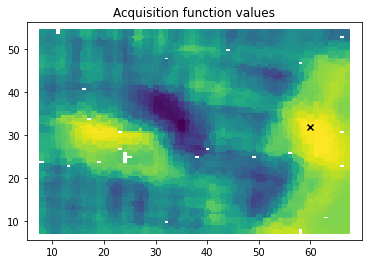

22/80


100%|██████████| 100/100 [00:01<00:00, 64.71it/s, init loss: 20151.9462, avg. loss [96-100]: 19064.5044]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3267
noise            0.0801


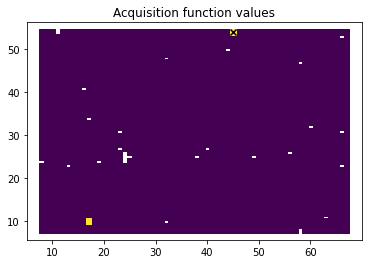

23/80


100%|██████████| 100/100 [00:01<00:00, 65.26it/s, init loss: 20153.1607, avg. loss [96-100]: 19064.6140]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.323
noise            0.0799


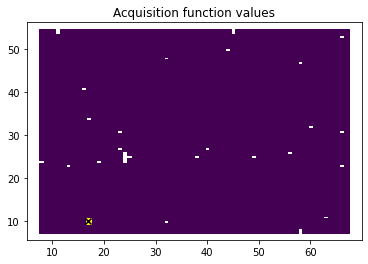

24/80


100%|██████████| 100/100 [00:01<00:00, 66.22it/s, init loss: 20154.3333, avg. loss [96-100]: 19082.4128]



Inferred GP kernel parameters
k_length         [2.7347 2.3203]
k_scale          0.2235
noise            0.0332


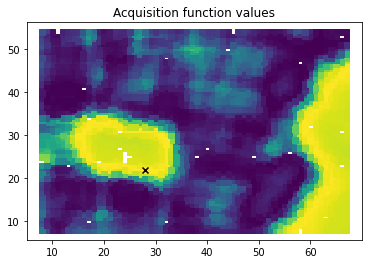

25/80


100%|██████████| 100/100 [00:01<00:00, 51.78it/s, init loss: 20155.5865, avg. loss [96-100]: 19095.1653]



Inferred GP kernel parameters
k_length         [2.4411 2.9913]
k_scale          0.2293
noise            0.0362


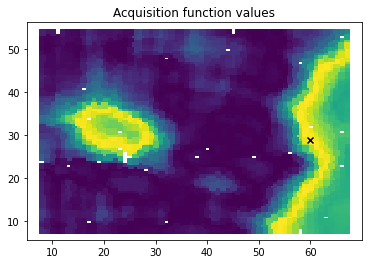

26/80


100%|██████████| 100/100 [00:01<00:00, 64.59it/s, init loss: 20156.9662, avg. loss [96-100]: 19064.6611]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3209
noise            0.07740000000000001


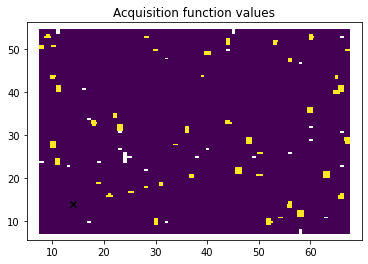

27/80


100%|██████████| 100/100 [00:01<00:00, 64.92it/s, init loss: 20158.1654, avg. loss [96-100]: 19064.6834]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3185
noise            0.07680000000000001


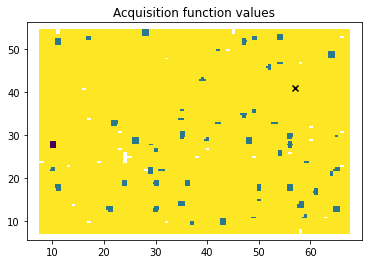

28/80


100%|██████████| 100/100 [00:01<00:00, 61.30it/s, init loss: 20159.4184, avg. loss [96-100]: 19076.7915]



Inferred GP kernel parameters
k_length         [3.0423 2.6397]
k_scale          0.199
noise            0.0304


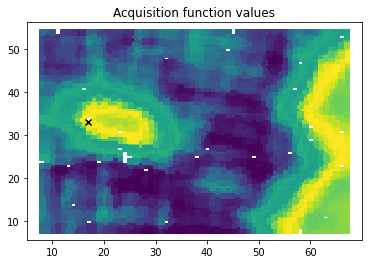

29/80


100%|██████████| 100/100 [00:01<00:00, 56.54it/s, init loss: 20160.8080, avg. loss [96-100]: 19105.6315]



Inferred GP kernel parameters
k_length         [2.8369 2.4322]
k_scale          0.2237
noise            0.0351


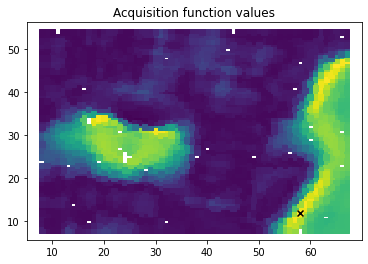

30/80


100%|██████████| 100/100 [00:01<00:00, 56.99it/s, init loss: 20162.2150, avg. loss [96-100]: 19103.2126]



Inferred GP kernel parameters
k_length         [3.5298 3.3551]
k_scale          0.2189
noise            0.032100000000000004


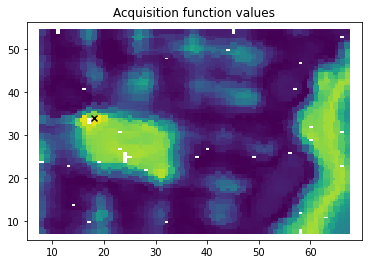

31/80


100%|██████████| 100/100 [00:01<00:00, 57.02it/s, init loss: 20163.6339, avg. loss [96-100]: 19066.2876]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3269
noise            0.0814


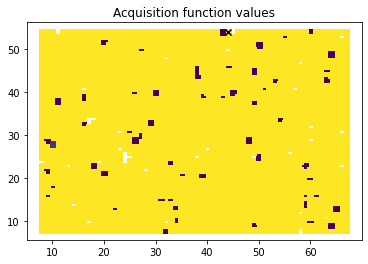

32/80


100%|██████████| 100/100 [00:02<00:00, 43.84it/s, init loss: 20164.8776, avg. loss [96-100]: 19071.2281]



Inferred GP kernel parameters
k_length         [2.6942 3.0788]
k_scale          0.23120000000000002
noise            0.0233


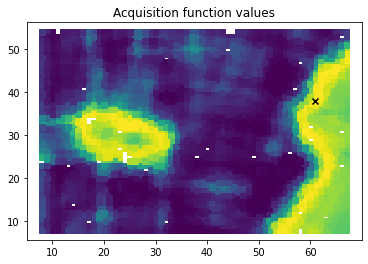

33/80


100%|██████████| 100/100 [00:01<00:00, 56.92it/s, init loss: 20166.2523, avg. loss [96-100]: 19103.5863]



Inferred GP kernel parameters
k_length         [2.2244 2.79  ]
k_scale          0.2222
noise            0.0274


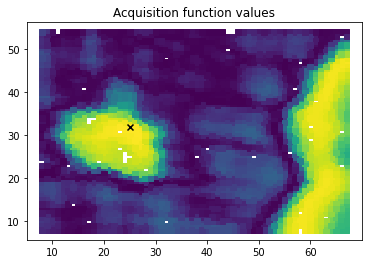

34/80


100%|██████████| 100/100 [00:01<00:00, 55.36it/s, init loss: 20167.5744, avg. loss [96-100]: 19084.4614]



Inferred GP kernel parameters
k_length         [4.1173 2.3856]
k_scale          0.21780000000000002
noise            0.0268


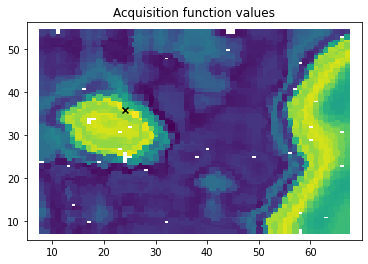

35/80


100%|██████████| 100/100 [00:02<00:00, 49.64it/s, init loss: 20168.9079, avg. loss [96-100]: 19129.2869]



Inferred GP kernel parameters
k_length         [4.6055 3.6269]
k_scale          0.2083
noise            0.0279


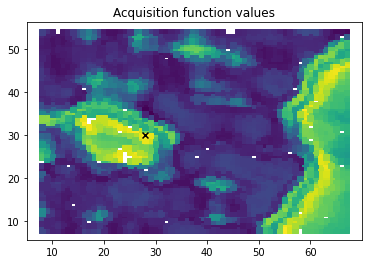

36/80


100%|██████████| 100/100 [00:01<00:00, 56.73it/s, init loss: 20170.1415, avg. loss [96-100]: 19120.5628]



Inferred GP kernel parameters
k_length         [3.7849 3.6685]
k_scale          0.2104
noise            0.0281


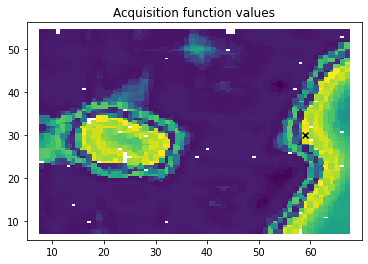

37/80


100%|██████████| 100/100 [00:01<00:00, 56.30it/s, init loss: 20171.4629, avg. loss [96-100]: 19174.5835]



Inferred GP kernel parameters
k_length         [3.0869 3.0889]
k_scale          0.2427
noise            0.0309


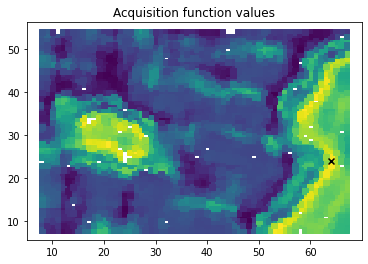

38/80


100%|██████████| 100/100 [00:02<00:00, 49.54it/s, init loss: 20172.7803, avg. loss [96-100]: 19133.7083]



Inferred GP kernel parameters
k_length         [3.7586 3.3251]
k_scale          0.23120000000000002
noise            0.0279


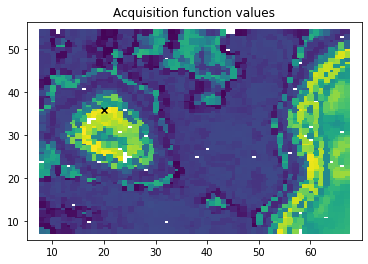

39/80


100%|██████████| 100/100 [00:01<00:00, 51.30it/s, init loss: 20174.2190, avg. loss [96-100]: 19090.4628]



Inferred GP kernel parameters
k_length         [3.7481 3.4114]
k_scale          0.2257
noise            0.0245


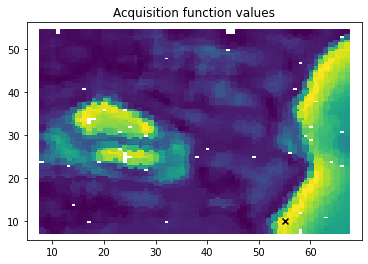

40/80


100%|██████████| 100/100 [00:01<00:00, 56.60it/s, init loss: 20175.5932, avg. loss [96-100]: 19124.6142]



Inferred GP kernel parameters
k_length         [4.0495 4.4424]
k_scale          0.21300000000000002
noise            0.0245


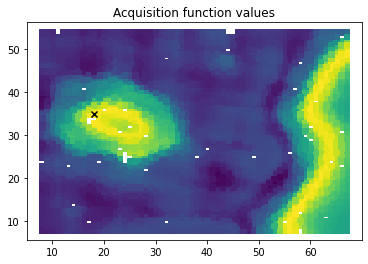

41/80


100%|██████████| 100/100 [00:02<00:00, 48.01it/s, init loss: 20176.8894, avg. loss [96-100]: 19122.4519]



Inferred GP kernel parameters
k_length         [3.7542 5.3646]
k_scale          0.23920000000000002
noise            0.0247


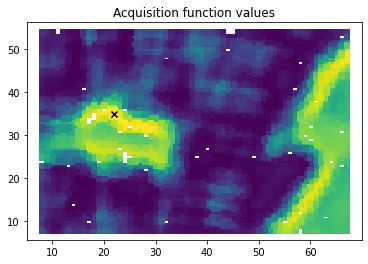

42/80


100%|██████████| 100/100 [00:01<00:00, 54.93it/s, init loss: 20178.2070, avg. loss [96-100]: 19145.7547]



Inferred GP kernel parameters
k_length         [5.0828 5.0498]
k_scale          0.24760000000000001
noise            0.027


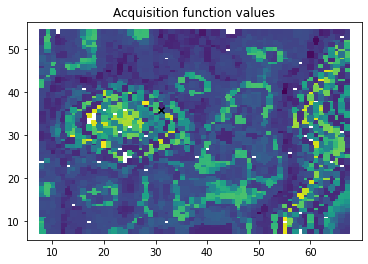

43/80


100%|██████████| 100/100 [00:01<00:00, 54.27it/s, init loss: 20179.4045, avg. loss [96-100]: 19125.4822]



Inferred GP kernel parameters
k_length         [5.4197 6.5123]
k_scale          0.182
noise            0.0281


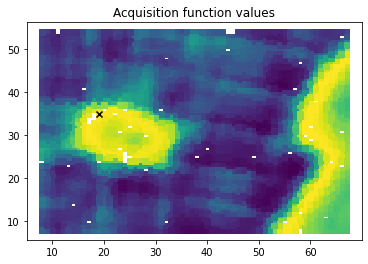

44/80


100%|██████████| 100/100 [00:02<00:00, 43.15it/s, init loss: 20180.6259, avg. loss [96-100]: 19123.7243]



Inferred GP kernel parameters
k_length         [5.0362 3.7528]
k_scale          0.1948
noise            0.028800000000000003


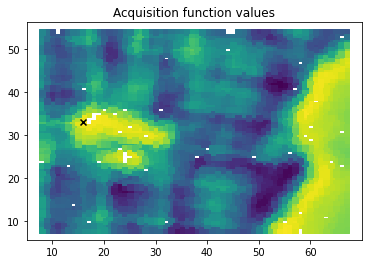

45/80


100%|██████████| 100/100 [00:01<00:00, 53.63it/s, init loss: 20181.9284, avg. loss [96-100]: 19086.4800]



Inferred GP kernel parameters
k_length         [3.1195 4.607 ]
k_scale          0.20350000000000001
noise            0.0221


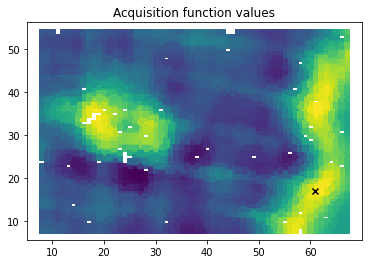

46/80


100%|██████████| 100/100 [00:01<00:00, 53.85it/s, init loss: 20183.2848, avg. loss [96-100]: 19080.7718]



Inferred GP kernel parameters
k_length         [5.3078 4.349 ]
k_scale          0.2018
noise            0.023


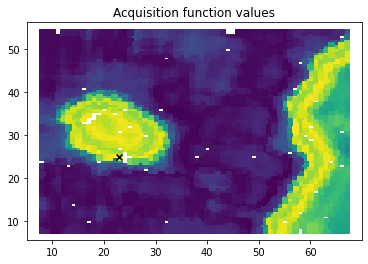

47/80


100%|██████████| 100/100 [00:01<00:00, 54.78it/s, init loss: 20184.5571, avg. loss [96-100]: 19119.5126]



Inferred GP kernel parameters
k_length         [6.3835 5.4331]
k_scale          0.2285
noise            0.024200000000000003


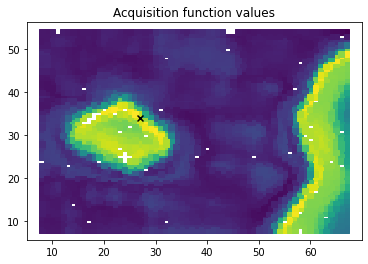

48/80


100%|██████████| 100/100 [00:01<00:00, 52.38it/s, init loss: 20185.8843, avg. loss [96-100]: 19105.6768]



Inferred GP kernel parameters
k_length         [4.451  5.6612]
k_scale          0.21230000000000002
noise            0.0233


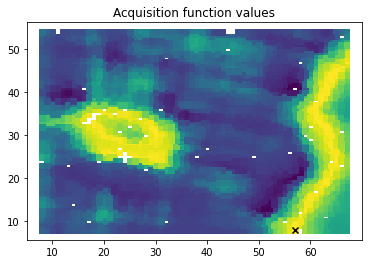

49/80


100%|██████████| 100/100 [00:02<00:00, 46.39it/s, init loss: 20187.2603, avg. loss [96-100]: 19067.4255]



Inferred GP kernel parameters
k_length         [6.2713 5.0187]
k_scale          0.2131
noise            0.0219


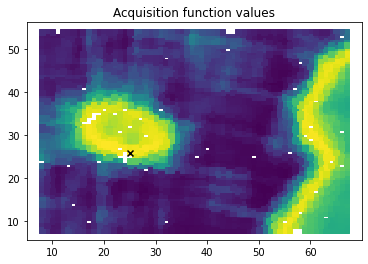

50/80


100%|██████████| 100/100 [00:01<00:00, 54.45it/s, init loss: 20188.5413, avg. loss [96-100]: 19113.3842]



Inferred GP kernel parameters
k_length         [3.7758 4.1534]
k_scale          0.2451
noise            0.0211


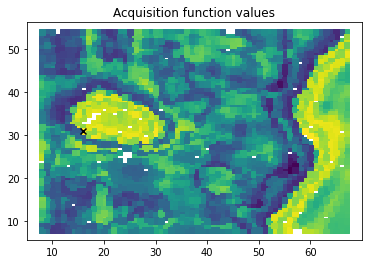

51/80


100%|██████████| 100/100 [00:01<00:00, 52.34it/s, init loss: 20189.8874, avg. loss [96-100]: 19108.0605]



Inferred GP kernel parameters
k_length         [7.4295 7.6867]
k_scale          0.1928
noise            0.0227


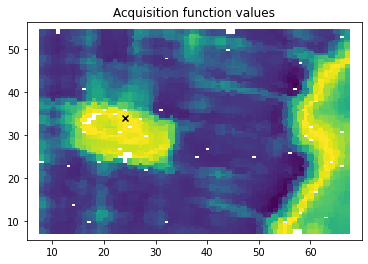

52/80


100%|██████████| 100/100 [00:01<00:00, 53.02it/s, init loss: 20191.1430, avg. loss [96-100]: 19089.1596]



Inferred GP kernel parameters
k_length         [5.8398 6.1851]
k_scale          0.2164
noise            0.023


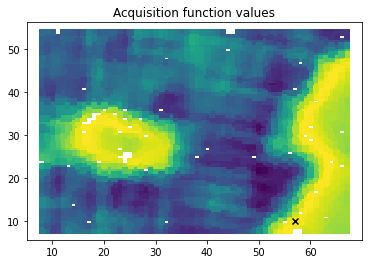

53/80


100%|██████████| 100/100 [00:01<00:00, 53.33it/s, init loss: 20192.5333, avg. loss [96-100]: 19065.0156]



Inferred GP kernel parameters
k_length         [4.4135 4.5649]
k_scale          0.2172
noise            0.019200000000000002


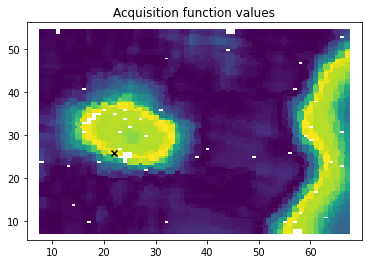

54/80


100%|██████████| 100/100 [00:02<00:00, 45.36it/s, init loss: 20193.8296, avg. loss [96-100]: 19081.1411]



Inferred GP kernel parameters
k_length         [6.4068 5.8495]
k_scale          0.22310000000000002
noise            0.023100000000000002


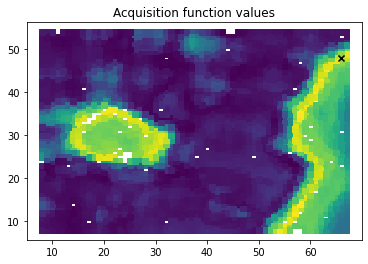

55/80


100%|██████████| 100/100 [00:01<00:00, 53.89it/s, init loss: 20195.1134, avg. loss [96-100]: 19099.5912]



Inferred GP kernel parameters
k_length         [5.7292 6.4777]
k_scale          0.2189
noise            0.0224


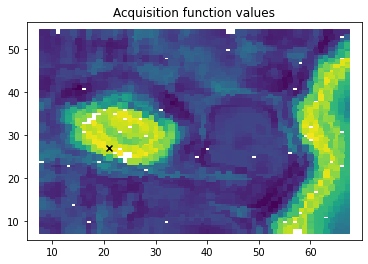

56/80


100%|██████████| 100/100 [00:01<00:00, 56.26it/s, init loss: 20196.3699, avg. loss [96-100]: 19081.3256]



Inferred GP kernel parameters
k_length         [4.0095 3.9994]
k_scale          0.2015
noise            0.019


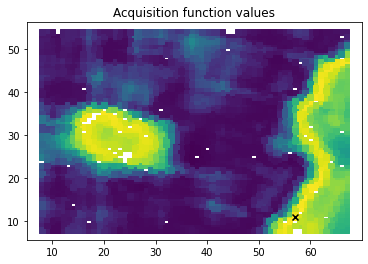

57/80


100%|██████████| 100/100 [00:01<00:00, 52.37it/s, init loss: 20197.6501, avg. loss [96-100]: 19099.6357]



Inferred GP kernel parameters
k_length         [6.2832 5.5384]
k_scale          0.2031
noise            0.0234


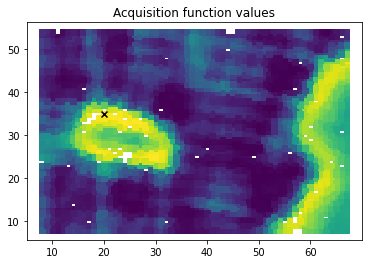

58/80


100%|██████████| 100/100 [00:01<00:00, 54.78it/s, init loss: 20199.0061, avg. loss [96-100]: 19146.2147]



Inferred GP kernel parameters
k_length         [6.5132 5.7218]
k_scale          0.1786
noise            0.0201


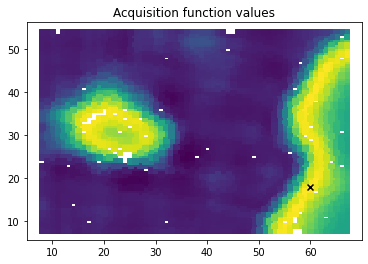

59/80


100%|██████████| 100/100 [00:02<00:00, 41.90it/s, init loss: 20200.2937, avg. loss [96-100]: 19070.0534]



Inferred GP kernel parameters
k_length         [5.0406 7.7285]
k_scale          0.1904
noise            0.020200000000000003


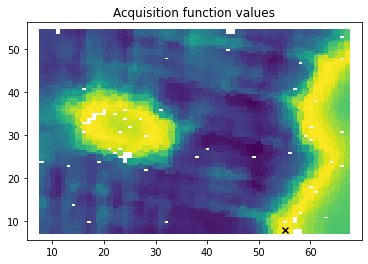

60/80


100%|██████████| 100/100 [00:01<00:00, 51.55it/s, init loss: 20201.7164, avg. loss [96-100]: 19085.5373]



Inferred GP kernel parameters
k_length         [4.5538 5.8358]
k_scale          0.2152
noise            0.022500000000000003


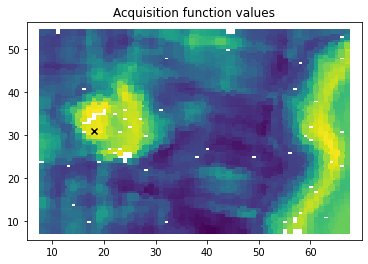

61/80


100%|██████████| 100/100 [00:01<00:00, 50.49it/s, init loss: 20202.9257, avg. loss [96-100]: 19169.8373]



Inferred GP kernel parameters
k_length         [ 9.7518 10.0044]
k_scale          0.2146
noise            0.025


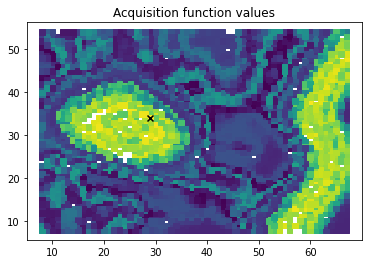

62/80


100%|██████████| 100/100 [00:02<00:00, 45.22it/s, init loss: 20204.2327, avg. loss [96-100]: 19071.8722]



Inferred GP kernel parameters
k_length         [5.8038 6.5243]
k_scale          0.2034
noise            0.0211


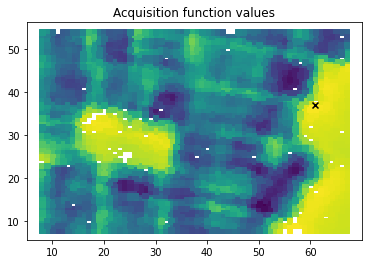

63/80


100%|██████████| 100/100 [00:01<00:00, 50.35it/s, init loss: 20205.5745, avg. loss [96-100]: 19123.2727]



Inferred GP kernel parameters
k_length         [11.5634  8.2813]
k_scale          0.2038
noise            0.0228


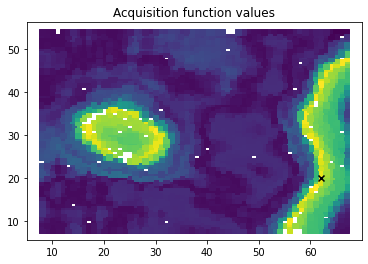

64/80


100%|██████████| 100/100 [00:02<00:00, 46.85it/s, init loss: 20206.8002, avg. loss [96-100]: 19142.4249]



Inferred GP kernel parameters
k_length         [9.6833 8.7514]
k_scale          0.1884
noise            0.0227


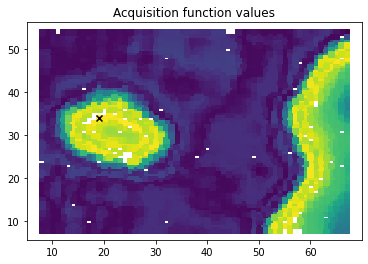

65/80


100%|██████████| 100/100 [00:01<00:00, 51.15it/s, init loss: 20207.9796, avg. loss [96-100]: 19116.4007]



Inferred GP kernel parameters
k_length         [7.555  6.6775]
k_scale          0.1728
noise            0.0212


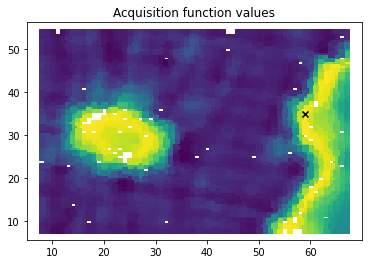

66/80


100%|██████████| 100/100 [00:02<00:00, 47.64it/s, init loss: 20209.3275, avg. loss [96-100]: 19094.5377]



Inferred GP kernel parameters
k_length         [6.3882 5.9847]
k_scale          0.18660000000000002
noise            0.020900000000000002


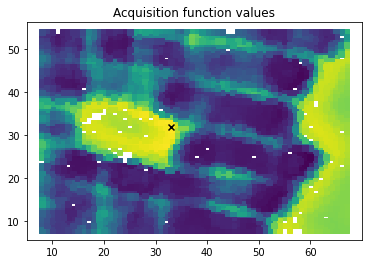

67/80


100%|██████████| 100/100 [00:02<00:00, 43.51it/s, init loss: 20210.6732, avg. loss [96-100]: 19133.2982]



Inferred GP kernel parameters
k_length         [8.9177 7.8556]
k_scale          0.1942
noise            0.0234


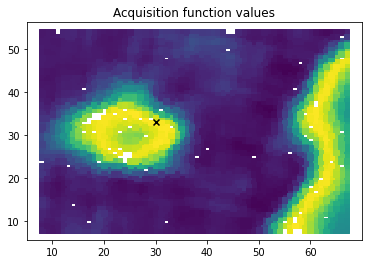

68/80


100%|██████████| 100/100 [00:01<00:00, 52.52it/s, init loss: 20211.8407, avg. loss [96-100]: 19113.5742]



Inferred GP kernel parameters
k_length         [6.5219 4.5613]
k_scale          0.2159
noise            0.021


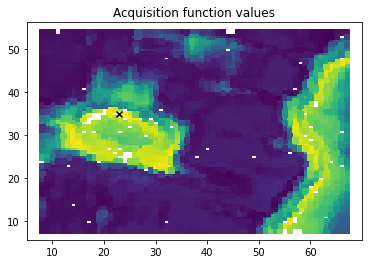

69/80


100%|██████████| 100/100 [00:01<00:00, 50.05it/s, init loss: 20213.1565, avg. loss [96-100]: 19071.2639]



Inferred GP kernel parameters
k_length         [6.1731 5.8753]
k_scale          0.192
noise            0.0171


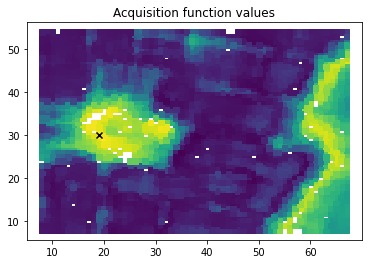

70/80


100%|██████████| 100/100 [00:01<00:00, 50.60it/s, init loss: 20214.3786, avg. loss [96-100]: 19106.4401]



Inferred GP kernel parameters
k_length         [10.3413  8.2905]
k_scale          0.1752
noise            0.017400000000000002


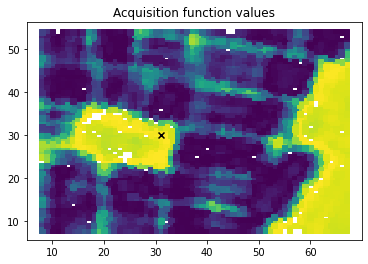

71/80


100%|██████████| 100/100 [00:01<00:00, 51.03it/s, init loss: 20215.6740, avg. loss [96-100]: 19091.2900]



Inferred GP kernel parameters
k_length         [6.6624 9.1298]
k_scale          0.19720000000000001
noise            0.0211


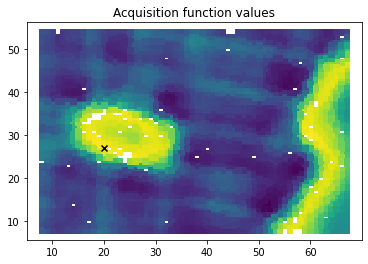

72/80


100%|██████████| 100/100 [00:02<00:00, 40.27it/s, init loss: 20216.9655, avg. loss [96-100]: 19055.2999]



Inferred GP kernel parameters
k_length         [5.3643 8.6124]
k_scale          0.19840000000000002
noise            0.017400000000000002


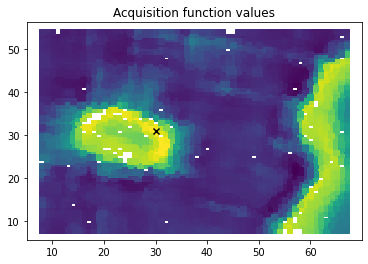

73/80


100%|██████████| 100/100 [00:01<00:00, 51.68it/s, init loss: 20218.2980, avg. loss [96-100]: 19046.1727]



Inferred GP kernel parameters
k_length         [ 6.1039 10.0753]
k_scale          0.2142
noise            0.0183


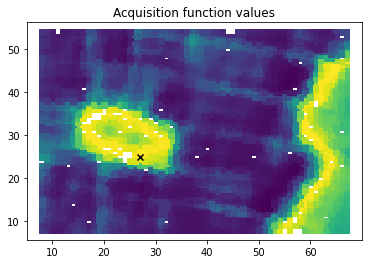

74/80


100%|██████████| 100/100 [00:01<00:00, 50.48it/s, init loss: 20219.6869, avg. loss [96-100]: 19072.9791]



Inferred GP kernel parameters
k_length         [4.9663 6.7884]
k_scale          0.2119
noise            0.019200000000000002


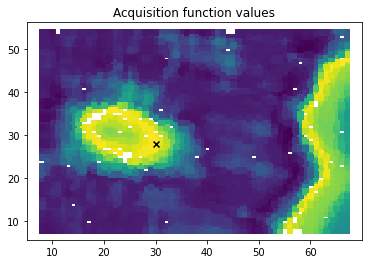

75/80


100%|██████████| 100/100 [00:02<00:00, 43.83it/s, init loss: 20220.8716, avg. loss [96-100]: 19093.9787]



Inferred GP kernel parameters
k_length         [8.8763 5.4716]
k_scale          0.1642
noise            0.0178


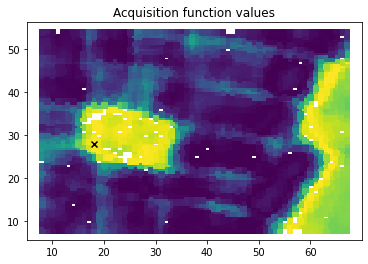

76/80


100%|██████████| 100/100 [00:01<00:00, 50.62it/s, init loss: 20222.2152, avg. loss [96-100]: 19111.2922]



Inferred GP kernel parameters
k_length         [9.1219 7.0448]
k_scale          0.187
noise            0.0205


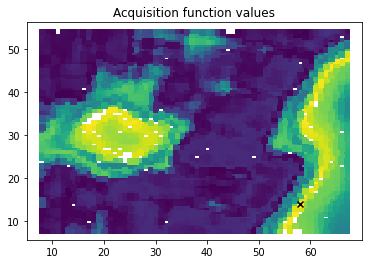

77/80


100%|██████████| 100/100 [00:02<00:00, 43.83it/s, init loss: 20223.4425, avg. loss [96-100]: 19170.4525]



Inferred GP kernel parameters
k_length         [9.8759 8.3684]
k_scale          0.1907
noise            0.021


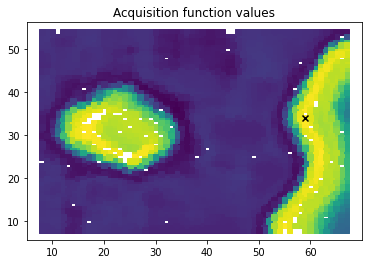

78/80


100%|██████████| 100/100 [00:01<00:00, 50.21it/s, init loss: 20224.7686, avg. loss [96-100]: 19074.0738]



Inferred GP kernel parameters
k_length         [5.9644 6.1662]
k_scale          0.18230000000000002
noise            0.019200000000000002


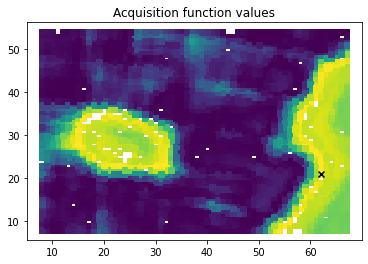

79/80


100%|██████████| 100/100 [00:02<00:00, 48.02it/s, init loss: 20226.0470, avg. loss [96-100]: 19063.7408]



Inferred GP kernel parameters
k_length         [5.4873 5.1784]
k_scale          0.2053
noise            0.017


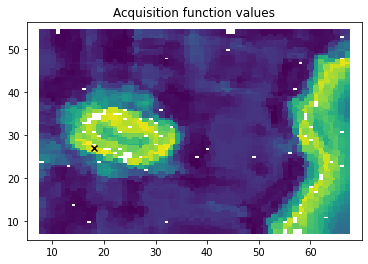

80/80


100%|██████████| 100/100 [00:02<00:00, 42.63it/s, init loss: 20227.2876, avg. loss [96-100]: 19095.6503]



Inferred GP kernel parameters
k_length         [ 8.4968 11.1343]
k_scale          0.1779
noise            0.0193


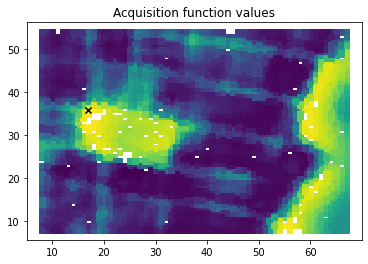

In [ ]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=32, c=obj, marker='s')
    next_point = indices[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_measured.shape[-1]

exploration_steps = 80

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)
    dkl.fit(  # you may decrease step size and increase number of steps (e.g. to 0.005 and 1000) for more stable performance
        key1, X_measured, y_measured, num_steps=100, step_size=0.05)
    # Compute UCB acquisition function
    obj = gpax.acquisition.UCB(key2, dkl, X_unmeasured, beta=0.25, maximize=True)
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    # Do "measurement"
    measured_point = y_unmeasured[next_point_idx]
    # Plot current result
    plot_result(indices_unmeasured, obj)
    # Update the arrays of measured/unmeasured points
    X_measured = np.append(X_measured, X_unmeasured[next_point_idx][None], 0)
    X_unmeasured = np.delete(X_unmeasured, next_point_idx, 0)
    y_measured = np.append(y_measured, measured_point)
    y_unmeasured = np.delete(y_unmeasured, next_point_idx)
    indices_measured = np.append(indices_measured, indices_unmeasured[next_point_idx][None], 0)
    indices_unmeasured = np.delete(indices_unmeasured, next_point_idx, 0)

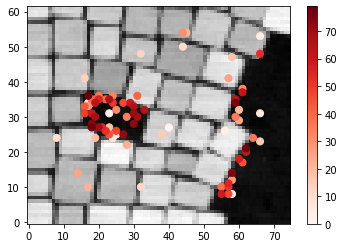

In [ ]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_measured[seed_points:, 1], indices_measured[seed_points:, 0],
            c=np.arange(len(indices_measured[seed_points:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

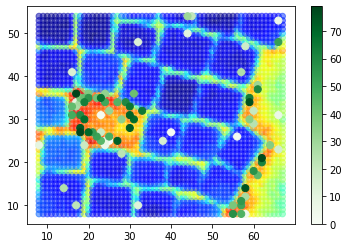

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_measured[seed_points:, 1], indices_measured[seed_points:, 0],
            c=np.arange(len(indices_measured[seed_points:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of interest is maximized.